Please upload a grayscale image (PNG/JPG)...


Saving golden_retriever_dog_animal.jpg to golden_retriever_dog_animal (2).jpg
Cover image shape: (256, 256)
Total carriers available (Max Capacity): 65517

Running performance tests...
Payload: 6551 bits (10%) → SSIM=0.9798, PSNR=41.05 dB
Payload: 18344 bits (28%) → SSIM=0.9454, PSNR=36.58 dB
Payload: 30137 bits (46%) → SSIM=0.9142, PSNR=34.43 dB
Payload: 41930 bits (64%) → SSIM=0.8850, PSNR=33.01 dB
Payload: 53723 bits (82%) → SSIM=0.8597, PSNR=31.97 dB
Payload: 65517 bits (100%) → SSIM=0.8356, PSNR=31.12 dB
...Experiment complete.

--- Accuracy Stats (at 100% Payload) ---
Maximum embedding capacity: 65517 bits
Bits matched: 63502/65517
Accuracy: 96.92%
Total errors: 2015
0 → 1 flips: 1003
1 → 0 flips: 1012

Generating visual comparison (Cover vs. Stego vs. Difference)...


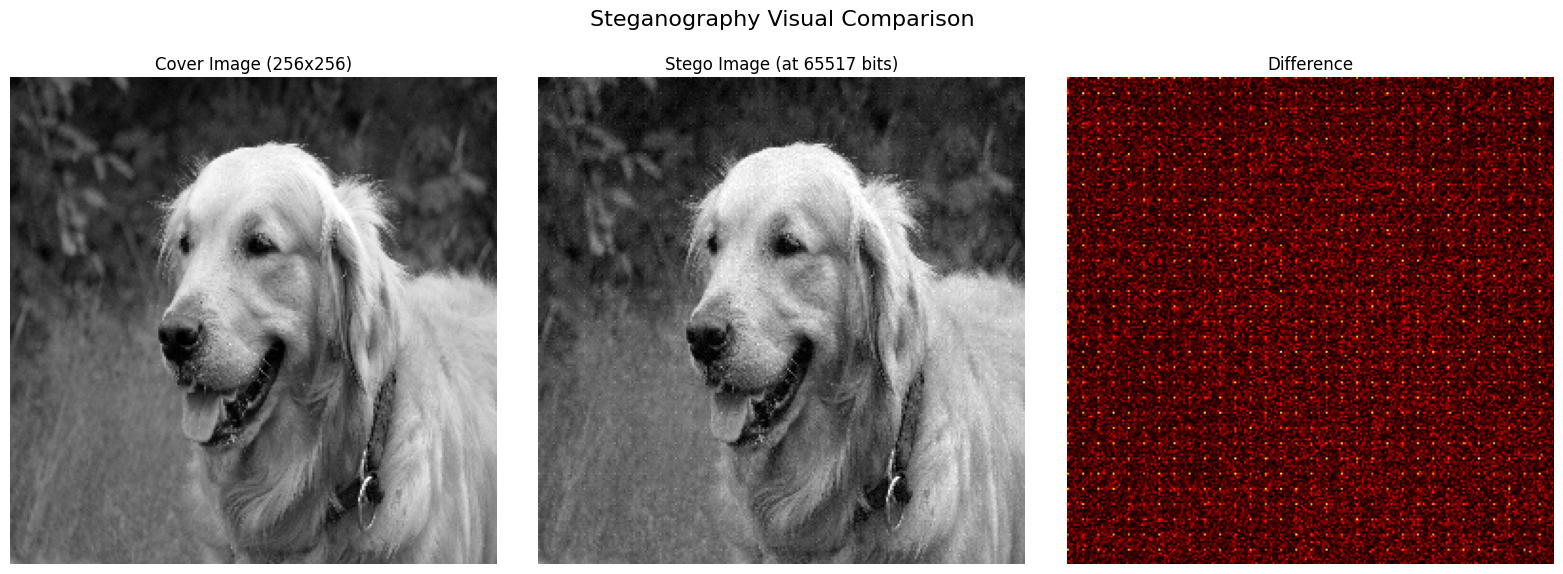


--- Final Quality Metrics (at 65517 bits) ---
Histogram Intersection: 0.9596
Root Mean Square Error (RMSE): 7.0868
Final SSIM: 0.8356
Final PSNR: 31.12 dB

Generating performance graphs...


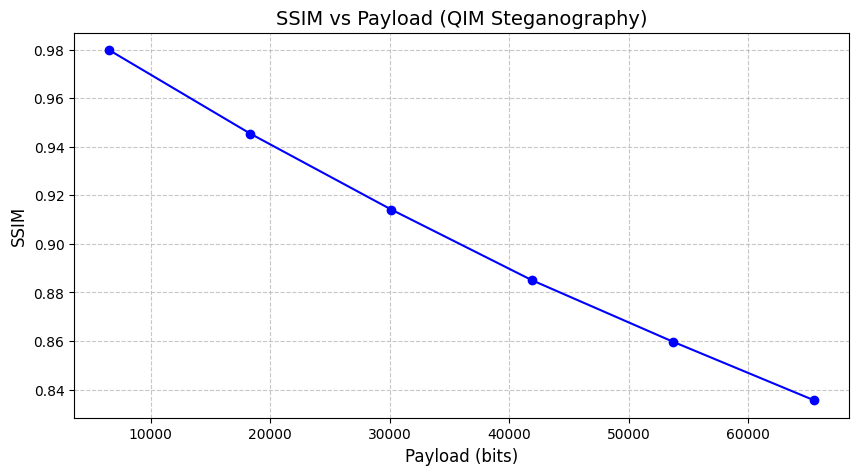

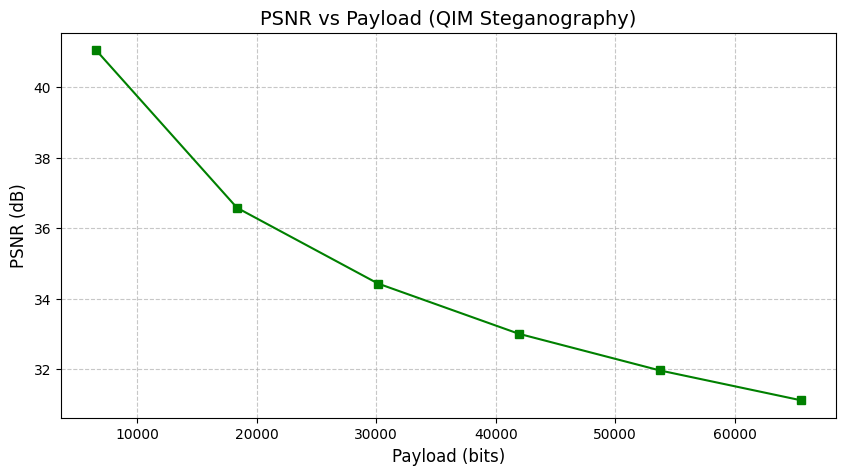

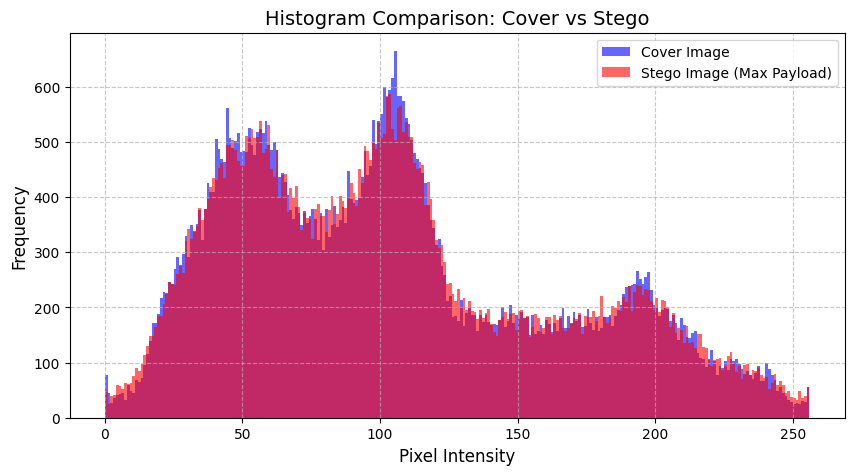

In [ ]:
# ============================================================
# QIM Steganography Performance Analysis
# Merged Code:
# 1. Accuracy Stats (Embed/Extract)
# 2. Visual Image Comparison (Cover vs. Stego vs. Diff)
# 3. SSIM, PSNR vs Payload Graphs
# 4. Histogram Comparison Graph & Metrics (RMSE)
# ============================================================

import numpy as np
import cv2
import pywt
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as peak_snr
from google.colab import files
import math

# ----------------------------
# USER PARAMETERS
# ----------------------------
block_size = 8
resize_to = (256, 256)
seed = 42
initial_Q = 8.0
include_dc = True
magnitude_threshold = 0.0

# ----------------------------
# QIM Functions
# ----------------------------
def qim_embed_coef(coef, bit, Q):
    """Embeds a bit using Quantization Index Modulation."""
    k = np.round(coef / (2.0 * Q))
    return (2.0 * k + float(bit)) * Q

def qim_extract_bit(coef, Q):
    """Extracts a bit using Quantization Index Modulation."""
    val = np.round(coef / Q)
    return int(np.abs(val) % 2)

# ----------------------------
# Transform helpers
# ----------------------------
def enumerate_carriers_for_block(block, include_dc=True, mag_thresh=0.0):
    """Finds all potential DCT and DWT coefficients in a block."""
    carriers_dct, carriers_dwt = [], []

    # DCT
    dctb = cv2.dct(block.astype(np.float32))
    for u in range(dctb.shape[0]):
        for v in range(dctb.shape[1]):
            if not include_dc and u == 0 and v == 0:
                continue
            if abs(dctb[u, v]) > mag_thresh:
                carriers_dct.append(('DCT', (u, v)))

    # DWT
    cA, (cH, cV, cD) = pywt.dwt2(block.astype(np.float32), 'haar')
    for band_name, band in (('cH', cH), ('cV', cV), ('cD', cD)):
        for r in range(band.shape[0]):
            for c in range(band.shape[1]):
                if abs(band[r, c]) > mag_thresh:
                    carriers_dwt.append(('DWT', (band_name, r, c)))

    # Return the list from the transform that yielded more carriers
    return carriers_dct, carriers_dwt

def read_carrier_from_block(block, carrier, transform_mode):
    """Reads the value of a specific coefficient from a block."""
    _, pos = carrier
    if transform_mode == 'DCT':
        dctb = cv2.dct(block.astype(np.float32))
        return dctb[pos]
    else:
        cA, (cH, cV, cD) = pywt.dwt2(block.astype(np.float32), 'haar')
        band_name, r, c = pos
        return {'cH': cH, 'cV': cV, 'cD': cD}[band_name][r, c]

def write_carrier_to_block(block, carrier, transform_mode, new_coef):
    """Writes a new value to a specific coefficient and returns the modified block."""
    _, pos = carrier
    if transform_mode == 'DCT':
        dctb = cv2.dct(block.astype(np.float32))
        dctb[pos] = new_coef
        block_mod = cv2.idct(dctb)
    else:
        cA, (cH, cV, cD) = pywt.dwt2(block.astype(np.float32), 'haar')
        band_name, r, c = pos
        if band_name == 'cH':
            cH[r, c] = new_coef
        elif band_name == 'cV':
            cV[r, c] = new_coef
        else:
            cD[r, c] = new_coef
        block_mod = pywt.idwt2((cA, (cH, cV, cD)), 'haar')

    return np.clip(np.round(block_mod), 0, 255).astype(np.uint8)

# ----------------------------
# Carrier Pool
# ----------------------------
def build_carrier_pools(cover, block_size, include_dc=True, mag_thresh=0.0):
    """Builds a shuffled list of all available carriers in the image."""
    H, W = cover.shape
    carriers = []
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            block = cover[i:i+block_size, j:j+block_size]
            dct_list, dwt_list = enumerate_carriers_for_block(block, include_dc, mag_thresh)

            # Choose the transform with more carriers for this block
            chosen = dct_list if len(dct_list) >= len(dwt_list) else dwt_list

            for t, pos in chosen:
                carriers.append(((i, j), t, pos)) # ((block_row, block_col), mode, (coef_row, coef_col))

    rng = np.random.RandomState(seed)
    # Shuffle the list and return
    return [carriers[k] for k in rng.permutation(len(carriers))]

# ----------------------------
# Embed/Extract Functions
# ----------------------------
def embed_to_carrier_list(cover, carrier_list, bits, Q):
    """Embeds a list of bits into the cover image using the carrier list."""
    stego = cover.copy()
    for idx, bit in enumerate(bits):
        (i, j), mode, pos = carrier_list[idx]
        block = stego[i:i+block_size, j:j+block_size]

        coef = read_carrier_from_block(block, ('', pos), mode)
        new_coef = qim_embed_coef(coef, int(bit), Q)
        stego[i:i+block_size, j:j+block_size] = write_carrier_to_block(block, ('', pos), mode, new_coef)

    return stego

def extract_from_carrier_list(stego, carrier_list, length, Q):
    """Extracts bits from a stego image using the carrier list."""
    bits = []
    for entry in carrier_list[:length]:
        (i, j), mode, pos = entry
        block = stego[i:i+block_size, j:j+block_size]
        coef = read_carrier_from_block(block, ('', pos), mode)
        bits.append(qim_extract_bit(coef, Q))
    return np.array(bits, dtype=int)


# ============================================================
#
# 1. LOAD IMAGE
#
# ============================================================
cover = load_image_colab(resize_to=resize_to, block_size=block_size)
print(f"Cover image shape: {cover.shape}")

rng = np.random.RandomState(seed)
carrier_list = build_carrier_pools(cover, block_size, include_dc, magnitude_threshold)
max_capacity = len(carrier_list)
print(f"Total carriers available (Max Capacity): {max_capacity}")


# ============================================================
#
# 2. RUN EXPERIMENT (FOR GRAPHS)
#
# ============================================================
payload_sizes_frac = np.linspace(0.1, 1.0, 6) # 10%, 28%, 46%, 64%, 82%, 100%
payload_sizes_bits = [int(p * max_capacity) for p in payload_sizes_frac]

ssim_vals, psnr_vals = [], []
stego_final = None  # To store the stego image with 100% payload
bits_final = None   # To store the bits for 100% payload

print("\nRunning performance tests...")
for bits_len in payload_sizes_bits:
    bits = rng.randint(0, 2, bits_len)
    stego = embed_to_carrier_list(cover, carrier_list, bits, initial_Q)

    s_val = ssim(cover, stego, data_range=255)
    p_val = peak_snr(cover, stego, data_range=255)

    ssim_vals.append(s_val)
    psnr_vals.append(p_val)
    stego_final = stego  # Keep the last one (max payload)
    bits_final = bits    # Keep the last bitstream

    print(f"Payload: {bits_len} bits ({bits_len/max_capacity*100:.0f}%) → SSIM={s_val:.4f}, PSNR={p_val:.2f} dB")

print("...Experiment complete.")


# ============================================================
#
# 3. CALCULATE FINAL ACCURACY
#
# ============================================================
print("\n--- Accuracy Stats (at 100% Payload) ---")

# Extract bits from the final stego image
recovered_payload = extract_from_carrier_list(stego_final, carrier_list, len(bits_final), initial_Q)
embedded_payload = bits_final

# Calculate accuracy
total_bits = len(embedded_payload)
matches = np.sum(embedded_payload == recovered_payload)
errors = total_bits - matches
accuracy = matches / total_bits * 100
flips_0to1 = np.sum((embedded_payload == 0) & (recovered_payload == 1))
flips_1to0 = np.sum((embedded_payload == 1) & (recovered_payload == 0))

print(f"Maximum embedding capacity: {max_capacity} bits")
print(f"Bits matched: {matches}/{total_bits}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Total errors: {errors}")
print(f"0 → 1 flips: {flips_0to1}")
print(f"1 → 0 flips: {flips_1to0}")


# ============================================================
#
# 4. PLOT: VISUAL COMPARISON
#
# ============================================================
print("\nGenerating visual comparison (Cover vs. Stego vs. Difference)...")
plt.figure(figsize=(16, 6)) # Wider for 3 images

# 1. Cover Image
plt.subplot(1, 3, 1)
plt.imshow(cover, cmap='gray')
plt.title(f'Cover Image ({cover.shape[0]}x{cover.shape[1]})')
plt.axis('off')

# 2. Stego Image
plt.subplot(1, 3, 2)
plt.imshow(stego_final, cmap='gray')
plt.title(f'Stego Image (at {payload_sizes_bits[-1]} bits)')
plt.axis('off')

# 3. Difference Image (RMSE removed from title)
plt.subplot(1, 3, 3)
diff_image = np.abs(cover.astype(np.float32) - stego_final.astype(np.float32))
rmse_val = np.sqrt(np.mean(diff_image ** 2)) # RMSE still calculated for console output
plt.imshow(diff_image, cmap='hot')
plt.title(f'Difference') # Title changed to just "Difference"
plt.axis('off')

plt.suptitle('Steganography Visual Comparison', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
plt.show()


# ============================================================
#
# 5. CALCULATE: RMSE & HISTOGRAM METRICS
#
# ============================================================
# Compute histograms
hist_cover, _ = np.histogram(cover.ravel(), bins=256, range=(0,256))
hist_stego, _ = np.histogram(stego_final.ravel(), bins=256, range=(0,256))

# Normalize histograms
hist_cover = hist_cover.astype(np.float32) / np.sum(hist_cover)
hist_stego = hist_stego.astype(np.float32) / np.sum(hist_stego)

# Histogram Intersection
intersection = np.sum(np.minimum(hist_cover, hist_stego))

print(f"\n--- Final Quality Metrics (at {payload_sizes_bits[-1]} bits) ---")
print(f"Histogram Intersection: {intersection:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse_val:.4f}")
print(f"Final SSIM: {ssim_vals[-1]:.4f}")
print(f"Final PSNR: {psnr_vals[-1]:.2f} dB")


# ============================================================
#
# 6. PLOT: GRAPHS
#
# ============================================================

# ----------------------------
# 6.1. PLOT: SSIM vs Payload
# ----------------------------
print("\nGenerating performance graphs...")
plt.figure(figsize=(10, 5))
plt.plot(payload_sizes_bits, ssim_vals, 'o-', color='blue')
plt.title("SSIM vs Payload (QIM Steganography)", fontsize=14)
plt.xlabel("Payload (bits)", fontsize=12)
plt.ylabel("SSIM", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# ----------------------------
# 6.2. PLOT: PSNR vs Payload
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(payload_sizes_bits, psnr_vals, 's-', color='green')
plt.title("PSNR vs Payload (QIM Steganography)", fontsize=14)
plt.xlabel("Payload (bits)", fontsize=12)
plt.ylabel("PSNR (dB)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# ----------------------------
# 6.3. PLOT: Histogram Comparison
# ----------------------------
plt.figure(figsize=(10, 5))
plt.hist(cover.ravel(), bins=256, range=(0,256), color='blue', alpha=0.6, label='Cover Image')
plt.hist(stego_final.ravel(), bins=256, range=(0,256), color='red', alpha=0.6, label='Stego Image (Max Payload)')
plt.title("Histogram Comparison: Cover vs Stego", fontsize=14)
plt.xlabel("Pixel Intensity", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
